In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import savefig
from sympy import integrate, exp, sin, log, oo, pi,symbols
import deepxde as dde
import scipy.io as scio
from mpl_toolkits.mplot3d import Axes3D
from deepxde.backend import tf
#import datetime
# import time
import os
from pylab import mpl
from scipy.signal import chirp, spectrogram
mpl.rcParams['font.sans-serif']=['Microsoft YaHei']
mpl.rcParams['axes.unicode_minus']=False
from matplotlib.pyplot import MultipleLocator
# import xlrd
# import xlwt
from sympy import *
import sympy as sp
# import torch

2025-01-02 16:12:28.464994: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
Using backend: tensorflow.compat.v1
Other supported backends: tensorflow, pytorch, jax, paddle.
paddle supports more examples now and is recommended.


Instructions for updating:
non-resource variables are not supported in the long term


2025-01-02 16:12:29.324360: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-01-02 16:12:29.328174: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-01-02 16:12:29.328257: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


Enable just-in-time compilation with XLA.




In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import savefig

import pandas as pd
def round_sf(x, significant_figure=3):
    fmt = "%%.%dg" % significant_figure
    if isinstance(x, np.ndarray):
        return np.array([float(fmt % i) for i in x])
    else:
        return float(fmt % x)

def to_scientific_notation(value, significant_figure=2):
    return f"{value:.{significant_figure}e}"

list_result = np.loadtxt('1.txt')[-1]
# list_result = list_result.reshape(12,1,1)
print(list_result)
list_result = round_sf(list_result, 3)
# 创建 DataFrame，将数组作为一行
df = pd.DataFrame([list_result], columns=[f"Value {i+1}" for i in range(len(list_result))])

# 保存到 Excel 文件
df.to_excel("results.xlsx", index=False)  # 不需要额外的索引


[7.00000000e-01 8.00000000e-01 2.16054942e-04 1.00739245e-03
 3.04530791e-03 1.09537974e-04 2.47943717e-05 2.74096489e-05
 5.87564920e-03 2.84088980e-04 1.57327207e-04 1.92200746e-04]


In [2]:
import os
os.environ['TF_XLA_FLAGS'] = '--tf_xla_auto_jit=2'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '0'
os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices'
tf.function(jit_compile=True)

<function tensorflow.python.eager.def_function.function.<locals>.decorated(inner_function)>

{W0: 0.0, fai0: -35.6428919622629, M0: 0.0, V0: 100.000000000000}


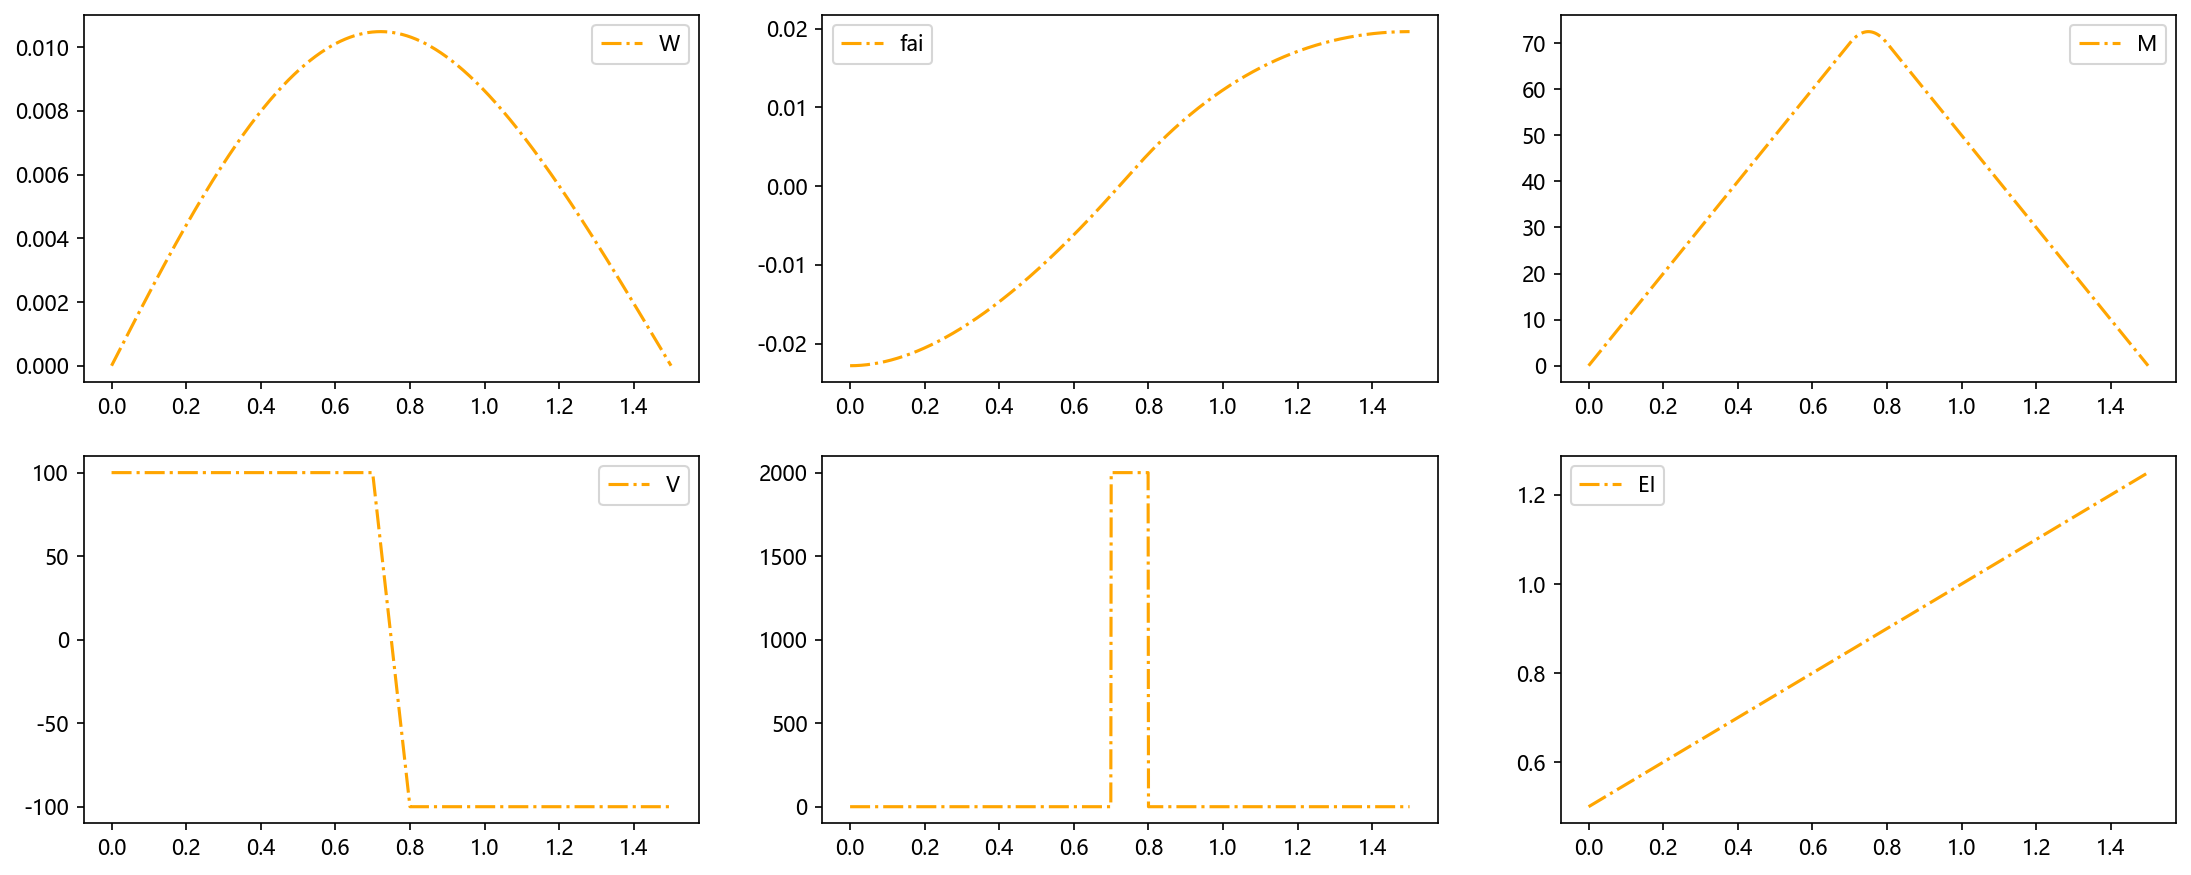

In [3]:
def Output(X):
    import re
    lines = open("s1.dat", "r").readlines()
    S = np.array([np.fromstring(min(re.findall(re.escape("[") + "(.*?)" + re.escape("]"), line),\
                                key=len),sep=",",) for line in lines ])
    dis = S[:,0:num_dis+2][-1]
    dis[0] = -0.2
    dis[-1] = 1.7
    interv = [ (X>=dis[i])&(X<dis[i+1]) for i in range(0,dis.shape[0]-1) ]
    out_all = model.predict(X)
    Y = out_all[:, 0: 5*num_NN]
    EI = out_all[:, 5*num_NN:5*num_NN+1] * EI_real
    Out = Y[:,0::num_NN][interv[0].ravel()]
    for i in range(1,num_NN):
        Out = np.vstack((Out, Y[:,i::num_NN][interv[i].ravel()]))
    Out = np.hstack((Out, EI))
    return [Out[:,i:i+1] for i in range(0,6)]

def Output_label(P = 0):
    pre_y1 = (model.predict(ob_x1)[:,num_NN*num_label]).reshape(-1,1)
    pre_y2 = (model.predict(ob_x2)[:,num_NN*num_label+1]).reshape(-1,1)
    pre_y3 = (model.predict(ob_x3)[:,num_NN*num_label+2]).reshape(-1,1)
    Pre_y = np.vstack(( pre_y1,pre_y2,pre_y3 ))
    if P == 1:
        return Pre_y
    return pre_y1,pre_y2,pre_y3

def Output_dNN(X, j = 0):
    import re
    lines = open("s1.dat", "r").readlines()
    S = np.array([np.fromstring(min(re.findall(re.escape("[") + "(.*?)" + re.escape("]"), line),\
                                key=len),sep=",",) for line in lines ])
    dis = S[:,0:num_dis+2][-1]
    dis[-1] = dis[-1]+0.001
    dis[0] = -0.2
    dis[-1] = 1.7
    interv = [ (X>=dis[i])&(X<dis[i+1]) for i in range(0,dis.shape[0]-1) ]
    Out_dNN = model.predict(X[interv[0].ravel()], operator=lambda x,y:dde.grad.jacobian(y,x, i=num_NN*j,j=0))
    for i in range(1,num_NN):
        Out_dNN = np.vstack((Out_dNN,model.predict(X[interv[i].ravel()], operator=\
                                               lambda x,y:dde.grad.jacobian(y,x, i=num_NN*j+i,j=0)) ))
    if j == 0 or j == 4: #u,fai,dfai,M,V   fai_dNN,dfai_dNN,XXX,V_dNN,q_dNN
        Out_dNN = -Out_dNN
    return Out_dNN

def Norm_exact(P = 0):
    import re
    lines = open("s1.dat", "r").readlines()
    S = np.array([np.fromstring(min(re.findall(re.escape("[") + "(.*?)" + re.escape("]"), line),\
                                key=len),sep=",",) for line in lines ])
    dis = S[:,0:num_dis+2][-1]
    dis[-1] = dis[-1]+0.001
    X = X1
    W,fai,dfai,M,V,EI = Output(X)
    Q = [Output_dNN(X, j = i) for i in [4]][0]
    pre_y1,pre_y2,pre_y3 = Output_label()
    EI_exact = NP_EI(X)
    norm_w = np.linalg.norm(W-WW1,ord=2) / np.linalg.norm(WW1,ord=2)
    norm_fai = np.linalg.norm(fai-dWW1,ord=2) / np.linalg.norm(dWW1,ord=2)
    norm_dfai = np.linalg.norm(dfai-dfai_real,ord=2) / np.linalg.norm(dfai_real,ord=2)
    norm_M = np.linalg.norm(M-ddWW1,ord=2) / np.linalg.norm(ddWW1,ord=2)
    norm_V = np.linalg.norm(V-dddWW1,ord=2) / np.linalg.norm(dddWW1,ord=2)
    norm_Q = np.linalg.norm(Q-ddddWW1,ord=2) / np.linalg.norm(ddddWW1,ord=2)
    norm_EI = np.linalg.norm(EI-EI_exact,ord=2) / np.linalg.norm(EI_exact,ord=2)
    norm = np.hstack((norm_w,norm_fai,norm_dfai,norm_M,norm_V,norm_Q,norm_EI))
    norm_y1 = np.linalg.norm(ob_y1-pre_y1,ord=2) / np.linalg.norm(ob_y1,ord=2)
    norm_y2 = np.linalg.norm(ob_y2-pre_y2,ord=2) / np.linalg.norm(ob_y3,ord=2)
    norm_y3 = np.linalg.norm(ob_y3-pre_y3,ord=2) / np.linalg.norm(ob_y3,ord=2)
    Norm = np.hstack((np.array(dis[1:-1]),norm,norm_y1,norm_y2,norm_y3))
    print(Norm)
    if P == 1:
        return Norm, [W,fai,dfai,M,V,Q,EI]
    return Norm

def Norm_NN( X, P = 0):
    u,fai,dfai,M,V,EI = Output(X)
    fai_dNN,dfai_dNN,V_dNN,Q_dNN = [Output_dNN(X, j = i) for i in [0,1,3,4]]
    Q = Q_dNN
    M_dNN = dfai*EI
    pre_y1,pre_y2,pre_y3 = Output_label()
    EI_exact = NP_EI(X)
    norm_fai_dNN = np.linalg.norm(fai-fai_dNN,ord=2) / np.linalg.norm(fai_dNN,ord=2)
    norm_dfai_dNN = np.linalg.norm(dfai-dfai_dNN,ord=2) / np.linalg.norm(dfai_dNN,ord=2)
    norm_M_dNN = np.linalg.norm(M-M_dNN,ord=2) / np.linalg.norm(M_dNN,ord=2)
    norm_V_dNN = np.linalg.norm(V-V_dNN,ord=2) / np.linalg.norm(V_dNN,ord=2)
    norm_Q_dNN = np.linalg.norm(Q_dNN-NP_Q(X),ord=2) / np.linalg.norm(NP_Q(X),ord=2)
    norm_y1 = np.linalg.norm(ob_y1-pre_y1,ord=2) / np.linalg.norm(ob_y1,ord=2)
    norm_y2 = np.linalg.norm(ob_y2-pre_y2,ord=2) / np.linalg.norm(ob_y3,ord=2)
    norm_y3 = np.linalg.norm(ob_y3-pre_y3,ord=2) / np.linalg.norm(ob_y3,ord=2)
    norm_EI = np.linalg.norm(EI-EI_exact,ord=2) / np.linalg.norm(EI_exact,ord=2)
    Norm = np.hstack((norm_fai_dNN,norm_dfai_dNN,norm_M_dNN,norm_V_dNN,norm_Q_dNN,norm_EI,norm_y1,norm_y2,norm_y3))
    print('norm_fai_dNN,norm_dfai_dNN,norm_M_dNN,norm_V_dNN,norm_Q_dNN,norm_EI,norm_y1,norm_y2,norm_y3')
    print(Norm)
    if P == 1:
        return Norm,[u,fai,dfai,M,V,Q,EI],[fai_dNN,dfai_dNN,V_dNN,Q_dNN]
    return Norm

%run CCF_x2_solution.ipynb

In [4]:
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
import numpy as np
import math
import matplotlib.pyplot as plt
 
from matplotlib import rcParams
 
config = {
            "font.family": 'serif',
            "font.size": 10.5,
            "mathtext.fontset": 'stix',
            "font.serif": ['MicroSoft YaHei'],
         }
rcParams.update(config)

In [5]:
def f_sig0(x_in,i):
    cond1 = tf.logical_and(tf.greater_equal(x_in, SS[i]), tf.less(x_in, SS[i+1]))
    f1 = tf.ones_like(x_in)
    f2 = tf.zeros_like(x_in)
    f = tf.where(cond1, f1, f2)
    return f
def beampde(x, y):
    x_in = x[:,0:1]
    u = y[:,0:num_NN]
    fai = y[:,num_NN:num_NN*2]
    M = y[:,num_NN*2:num_NN*3]
    V = y[:,num_NN*3:num_NN*4]
    EI = y[:,num_NN*4:num_NN*5]

    Fai_dNN = []
    M_dNN = []
    V_dNN = []
    Q_dNN = []
    for i in range(num_NN):
        fai_dNN = -dde.grad.jacobian(u, x, i = i, j=0)
        m_dNN = EI[:,i:i+1] * dde.grad.jacobian(fai, x, i = i, j=0)
        v_dNN = dde.grad.jacobian(M, x, i = i, j=0)
        q_dNN = -dde.grad.jacobian(V, x, i = i, j=0)
        Fai_dNN.append(fai_dNN)
        M_dNN.append(m_dNN)
        V_dNN.append(v_dNN)
        Q_dNN.append(q_dNN)

    f_sig = []
    for i in range(num_NN):
        f_sig.append( 10*tf.keras.activations.relu((x_in-SS[i])) * tf.keras.activations.relu((-x_in+SS[i+1])) )
        
    loss = []
    for i in range(num_NN):
        loss.append((fai[:,i:i+1]-Fai_dNN[i]) * f_sig[i])
        loss.append((M[:,i:i+1]-M_dNN[i]) * f_sig[i])
        loss.append((V[:,i:i+1]-V_dNN[i]) * f_sig[i])
        loss.append((f(x_in)-Q_dNN[i]) * f_sig[i])
        loss.append((TF_EI(x_in)-EI[:,i:i+1]) * f_sig[i])
    return loss

In [6]:
s0 = tf.Variable(0, trainable=False, dtype=tf.float32)
s1 = tf.Variable(L/2-L_dis/2, trainable=False, dtype=tf.float32)
s2 = tf.Variable(L/2+L_dis/2, trainable=False, dtype=tf.float32)
s3 = tf.Variable(L, trainable=False, dtype=tf.float32)
SS = [s0,s1,s2,s3]

num_dis = len(SS)-2
num_NN = num_dis+1

CC = []
for i in range(num_dis*6):
    CC.append(tf.Variable(0, trainable=True, dtype=tf.float32))
VV = SS.copy() 
VV.extend(CC)
c1 = CC[0]
c2 = CC[1]
c3 = CC[2]
c4 = CC[3]
c5 = CC[4]
c6 = CC[5]
c7 = CC[6]
c8 = CC[7]
c9 = CC[8]
c10 = CC[9]
c11 = CC[10]
c12 = CC[11]
#网络尺寸因子
P0 = (tf.Variable(0.1, trainable=True, dtype=tf.float32))
P1 = (tf.Variable(0.1, trainable=True, dtype=tf.float32))
P2 = (tf.Variable(0.1, trainable=True, dtype=tf.float32))
P3 = (tf.Variable(0.1, trainable=True, dtype=tf.float32))*EI_real
P4 = (tf.Variable(0.1, trainable=True, dtype=tf.float32))*EI_real

In [10]:
L/2-L_dis/2

0.7

In [7]:
def NP_EI(x_in):
    f1 = EI_real*(0.75+(x_in/L-0.5)**2)
    return f1

In [8]:
import scipy.io as scio
file_name='D0.05.mat'

num_node = 1500
Length_node = 1.5/num_node

Data = scio.loadmat(file_name)
All_w_data = Data["D0"].reshape(-1,1)
All_fai_data = -Data["Fai0"].reshape(-1,1)
X = Data['xx'].reshape(-1,1)

WW1 = All_w_data
dWW1 = All_fai_data
dfai_real = ddWW1/NP_EI(X1)

obXY_matlab = np.hstack((X,All_w_data))
ob_x1_index = (np.array([0.25, 0.5])/Length_node).astype(int).reshape(-1,1)
ob_x2_index = (np.array([0.75 ])/Length_node).astype(int).reshape(-1,1)
ob_x3_index = (np.array([1., 1.25])/Length_node).astype(int).reshape(-1,1)

ob_x1 = X[ob_x1_index].reshape(-1,1)
ob_x2 = X[ob_x2_index].reshape(-1,1)
ob_x3 = X[ob_x3_index].reshape(-1,1)
ob_y1 = All_w_data[ob_x1_index].reshape(-1,1)
ob_y2 = All_w_data[ob_x2_index].reshape(-1,1)
ob_y3 = All_w_data[ob_x3_index].reshape(-1,1)

ob_X = np.vstack((ob_x1,ob_x2,ob_x3))
ob_Y = np.vstack((ob_y1,ob_y2,ob_y3))
ob_XY = np.hstack((ob_X,ob_Y))
num_label = 0
observe_u1 = dde.PointSetBC(ob_x1,ob_y1,component=num_NN*num_label)
observe_u2 = dde.PointSetBC(ob_x2,ob_y2,component=num_NN*num_label+1)
observe_u3 = dde.PointSetBC(ob_x3,ob_y3,component=num_NN*num_label+2)

In [11]:
K = 4
np.random.seed(K)
tf.set_random_seed(K)

num_domain = 0
epochs = 10000
lr = 1e-3
u_nodenum=20
u_layer=2
E_nodenum=20
E_layer=2
activation_func1 = tf.nn.tanh
activation_func2 = tf.nn.elu

rho = 1180
A = 0.05*0.05
EI_real = 3e9*0.05*0.05**3/12
L = 1.5
T = 0.2
F = 200
w0 = 5*2*np.pi

anchors_x = np.hstack((np.random.uniform(0,1.5,200),np.random.uniform(L/2-L_dis,L/2+L_dis,20))).reshape(-1,1)
# anchors_x = (np.random.uniform(0,L,200).reshape(-1,1))

def f(x_in):
    cond1 = tf.logical_and(tf.greater_equal(x_in, L/2-L_dis/2), tf.less(x_in, L/2+L_dis/2))
    f1 = F/L_dis * tf.ones_like(x_in)
    f2 = tf.zeros_like(x_in)
    f = tf.where(cond1, f1, f2)
    return f
             
def NP_Q(x_in):
    cond1 = np.logical_and(np.greater_equal(x_in, L/2-L_dis/2), np.less(x_in, L/2+L_dis/2))
    f1 = F/L_dis * np.ones_like(x_in)
    f2 = np.zeros_like(x_in)
    f = np.where(cond1, f1, f2)
    return f
def TF_EI(x_in):
    f1 = EI_real*(x_in+1)/2
    return f1
def NP_EI(x_in):
    f1 = EI_real*(0.75+(x_in/L-0.5)**2)
    return f1

def f_BC_zero(x_in):
    cond1 = tf.logical_and(tf.greater_equal(x_in, 0.1), tf.less_equal(x_in, L-0.1))
    f1 = tf.ones_like(x_in)
    f2 = tf.zeros_like(x_in)
    f = tf.where(cond1, f1, f2)
    return f

def f_zero(x_in):
    cond1 = tf.logical_and(tf.greater_equal(x_in, 0), tf.less_equal(x_in, L))
    f1 = tf.ones_like(x_in)
    f2 = tf.zeros_like(x_in)
    f = tf.where(cond1, f1, f2)
    return f


def beampde2(x, y):
    x_in = x[:,0:1]
    u    = y[:,0:num_NN]
    Fai  = y[:,num_NN*1:num_NN*2]
    Dfai = y[:,num_NN*2:num_NN*3]
    M    = y[:,num_NN*3:num_NN*4]
    V    = y[:,num_NN*4:num_NN*5]
    EI = EI_real * y[:,num_NN*5:num_NN*5+1]

    Fai_dNN = []
    Dfai_dNN = []
    M_dNN = []
    V_dNN = []
    V2_dNN = []
    Q_dNN = []
    
    dEI_dNN = dde.grad.jacobian(EI, x, i = 0, j=0)

    for i in range(num_NN):
        fai_dNN = -dde.grad.jacobian(u, x, i = i, j=0)
        # dfai_dNN =  dde.grad.jacobian(Fai, x, i = i, j=0) * tf.sign(tf.nn.relu(x_in-0)*tf.nn.relu(-(x_in-1.5)))
        dfai_dNN =  dde.grad.jacobian(Fai, x, i = i, j=0) 
        m_dNN = EI * Dfai[:,i:i+1]
        v_dNN = dde.grad.jacobian(M, x, i = i, j=0)
        
        dc = dde.grad.jacobian(Dfai, x, i = i, j=0)
        v2_dNN = dEI_dNN*Dfai[:,i:i+1] + EI*dc
        
        q_dNN = -dde.grad.jacobian(V, x, i = i, j=0)
        Fai_dNN.append(fai_dNN)
        Dfai_dNN.append(dfai_dNN)
        M_dNN.append(m_dNN)
        V_dNN.append(v_dNN)
        V2_dNN.append(v2_dNN)
        Q_dNN.append(q_dNN)

    # f_sig = []
    # for i in range(num_NN):
    #     f_sig.append( 10*tf.keras.activations.relu((x_in-SS[i])) * tf.keras.activations.relu((-x_in+SS[i+1])) )
    # * tf.nn.tanh(tf.nn.relu( tf.abs(M[:,i:i+1]) )) 
    loss_Fai = 0
    loss_Dfai = 0
    loss_M = 0
    loss_V = 0
    loss_V2 = 0
    loss_Q = 0
    loss_EI = 0

    for i in range(num_NN):
        Weight_M =  tf.sign (tf.tanh(tf.nn.relu( tf.abs(M[:,i:i+1]) - 10)))
        
        loss_Fai = loss_Fai + (Fai[:,i:i+1]-Fai_dNN[i]) * f_sig0(x_in,i)
        loss_Dfai = loss_Dfai + (Dfai[:,i:i+1] - Dfai_dNN[i]) \
        * f_sig0(x_in,i) * f_BC_zero(x_in)
        # loss_M = loss_M + (M[:,i:i+1]-M_dNN[i]) * f_sig0(x_in,i) * tf.nn.tanh(tf.nn.relu( tf.abs(M[:,i:i+1]) )) 
        loss_M = loss_M + (M[:,i:i+1]-M_dNN[i]) * f_sig0(x_in,i) 
        loss_V = loss_V + (V[:,i:i+1]-V_dNN[i]) * f_sig0(x_in,i)
        loss_Q = loss_Q + (f(x_in)-Q_dNN[i]) * f_sig0(x_in,i)
        loss_EI = loss_EI + (TF_EI(x_in)-EI) * f_sig0(x_in,i)
        loss_V2 = loss_V2 + (V[:,i:i+1]-V2_dNN[i]) * f_sig0(x_in,i)
        loss_Dfai2 = loss_Dfai + (Dfai[:,i:i+1] - Dfai_dNN[i]) \
        * f_sig0(x_in,i)
    return [10*loss_Fai,
            10*loss_Dfai,
            loss_M/EI_real,\
            loss_V/EI_real,
            loss_Q/EI_real,
            loss_Dfai2/EI_real,
            loss_V2/EI_real/10]


def Boun_func1(x,y):
    dfai = dde.grad.jacobian(y,x, i =num_NN*1 , j= 0)
    return dfai
def Boun_func2(x,y):
    dfai = dde.grad.jacobian(y,x, i =num_NN*2 -1, j= 0)
    return dfai
geom = dde.geometry.Interval(0, L)

BC1 = dde.icbc.OperatorBC(geom, lambda x, y, _: Boun_func1(x,y),lambda x, _: np.isclose(x[0], 0))
BC2 = dde.icbc.OperatorBC(geom, lambda x, y, _: Boun_func2(x,y),lambda x, _: np.isclose(x[0], L))

data = dde.data.TimePDE(geom,beampde2,[observe_u1,observe_u2,observe_u3], num_domain=num_domain,anchors=anchors_x)

net = dde.maps.FNN([1]  + [50]*3 + [num_NN*5+1], "tanh", "Glorot uniform")

def modify_output(X, y):
    x = X[:,0:1]
    u    = y[:,0:num_NN]
    Fai  = y[:,num_NN*1:num_NN*2]
    Dfai = y[:,num_NN*2:num_NN*3]
    M    = y[:,num_NN*3:num_NN*4]
    V    = y[:,num_NN*4:num_NN*5]
    EI   = y[:,num_NN*5:num_NN*5+1]
    
    # Dfai = tf.layers.dense(x, u_nodenum, tf.nn.sigmoid)
    # Dfai = tf.layers.dense(Dfai, u_nodenum, tf.nn.sigmoid)
    # Dfai = tf.layers.dense(Dfai, u_nodenum, tf.nn.sigmoid)
    # Dfai = tf.layers.dense(Dfai, num_NN, None)

    final_output = tf.concat([P0*(x*u[:,0:1]*(x-s1)+c1*x/s1),\
                              P0*(u[:,1:2]*(x-s1)*(x-s2)+c1*(x-s2)/(s1-s2)+c2*(x-s1)/(s2-s1)),\
                              P0*(u[:,2:3]*(x-L)*(x-s2)+c2*(x-L)/(s2-L)),\
                              P1*(Fai[:,0:1]*(x-s1)+c3), \
                              P1*(Fai[:,1:2]*(x-s1)*(x-s2)+c3*(x-s2)/(s1-s2)+c4*(x-s1)/(s2-s1)),\
                              P1*(Fai[:,2:3]*(x-s2)+c4), \
                              P2*(x*Dfai[:,0:1]*(x-s1) + c9*x/s1),\
                              P2*(Dfai[:,1:2]*(x-s1)*(x-s2)+c9*(x-s2)/(s1-s2)+c10*(x-s1)/(s2-s1)),\
                              P2*(Dfai[:,2:3]*(x-L)*(x-s2)+c10*(x-L)/(s2-L)),\
                              P3*(x*M[:,0:1]*(x-s1)+c5*x/s1),\
                              P3*(M[:,1:2]*(x-s1)*(x-s2)+c5*(x-s2)/(s1-s2)+c6*(x-s1)/(s2-s1)),\
                              P3*(M[:,2:3]*(x-L)*(x-s2)+c6*(x-L)/(s2-L)),\
                              P4*(V[:,0:1]*(x-s1)+c7),\
                              P4*(V[:,1:2]*(x-s1)*(x-s2)+c7*(x-s2)/(s1-s2)+c8*(x-s1)/(s2-s1)),\
                              P4*(V[:,2:3]*(x-s2)+c8),\
                              tf.nn.softplus(EI)], axis=1)
    return final_output

net.apply_output_transform(modify_output)
variable = dde.callbacks.VariableValue(VV, period=200, filename="s1.dat")#200为epochs之间的间隔
variable2 = dde.callbacks.VariableValue([P0,P1,P2,P3,P4], period=200, filename="w1.dat")#200为epochs之间的间隔
model = dde.Model(data, net)

loss = []
Weight = np.ones(10)
Weight[-3:] = 100
for i in range(7):
    loss.append('MAE')
for i in range(3):
    loss.append('MAE')
# loss[0] = 'MAE'
loss[5] = 'zero'
loss[6] = 'zero'
model.compile("adam", lr, loss_weights=list(Weight.ravel()), loss = loss)
losshistory, train_state = model.train(epochs=20000, callbacks=[variable,variable2])
list_reslut = Norm_exact()
List_weight = []
list_point = []
list_Norm_dNN = []
list_NN =[]
list_dNN =[]
Norm,[u,fai,dfai,M,V,Q,EI],[fai_dNN,dfai_dNN,V_dNN,Q_dNN] = Norm_NN(X1, P = 1)
list_Norm_dNN.append(Norm)
list_NN.append(np.array([u,fai,dfai,M,V,Q,EI]).reshape(7,-1).T)
list_dNN.append(np.array([fai_dNN,dfai_dNN,V_dNN,Q_dNN]).reshape(4,-1).T)

Compiling model...
Building feed-forward neural network...
'build' took 0.063804 s



/home/pms/anaconda3/envs/tensorflow/lib/python3.9/site-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(
2025-01-02 16:13:14.473371: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-02 16:13:14.474168: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-01-02 16:13:14.474337: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must 

'compile' took 21.895364 s



2025-01-02 16:13:36.664637: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:354] MLIR V1 optimization pass is not enabled
2025-01-02 16:13:37.397563: I tensorflow/compiler/xla/service/service.cc:170] XLA service 0x7ff2c4022ec0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-01-02 16:13:37.397580: I tensorflow/compiler/xla/service/service.cc:178]   StreamExecutor device (0): NVIDIA GeForce RTX 4070 Ti, Compute Capability 8.9
2025-01-02 16:13:37.408249: W tensorflow/stream_executor/gpu/asm_compiler.cc:230] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.9
2025-01-02 16:13:37.408260: W tensorflow/stream_executor/gpu/asm_compiler.cc:233] Used ptxas at ptxas
2025-01-02 16:13:37.408378: I tensorflow/compiler/jit/xla_compilation_cache.cc:478] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Training model...



2025-01-02 16:13:39.119734: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:263] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-01-02 16:13:39.911705: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] UNIMPLEMENTED: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2025-01-02 16:13:39.914268: W tensorflow/compiler/xla/service/gpu/buffer_comparator.cc:640] UNIMPLEMENTED: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Setting XLA_FLAGS=--xla_gpu_cuda_data_dir=/path/to/cuda  or modifying $PATH can be used to set the location of ptxas
This message will only be logged once.


Step      Train loss                                                                                              Test loss                                                                                               Test metric
0         [9.65e-02, 1.05e-01, 2.27e-04, 4.85e-03, 1.27e-01, 0.00e+00, 0.00e+00, 6.87e-01, 1.16e+00, 1.13e+00]    [9.65e-02, 1.05e-01, 2.27e-04, 4.85e-03, 1.27e-01, 0.00e+00, 0.00e+00, 6.87e-01, 1.16e+00, 1.13e+00]    []  
1000      [3.89e-03, 9.81e-03, 1.83e-04, 3.87e-04, 7.09e-04, 0.00e+00, 0.00e+00, 4.64e-03, 9.77e-04, 1.53e-02]    [3.89e-03, 9.81e-03, 1.83e-04, 3.87e-04, 7.09e-04, 0.00e+00, 0.00e+00, 4.64e-03, 9.77e-04, 1.53e-02]    []  
2000      [3.10e-03, 5.42e-03, 1.66e-04, 1.27e-04, 2.64e-04, 0.00e+00, 0.00e+00, 1.20e-03, 3.70e-04, 3.46e-03]    [3.10e-03, 5.42e-03, 1.66e-04, 1.27e-04, 2.64e-04, 0.00e+00, 0.00e+00, 1.20e-03, 3.70e-04, 3.46e-03]    []  
3000      [2.29e-03, 4.62e-03, 1.84e-04, 1.94e-04, 1.95e-04, 0.00e+00, 0.00e+00, 4.05e-03, 7.53e-04, 

2025-01-02 16:15:00.979711: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


[7.00000000e-01 8.00000000e-01 1.92820399e-03 1.22765850e-02
 1.71449726e-02 5.54628497e-04 7.35554768e-04 1.17686336e-03
 1.07003290e-01 2.13510951e-03 1.00348367e-03 2.54791121e-03]
norm_fai_dNN,norm_dfai_dNN,norm_M_dNN,norm_V_dNN,norm_Q_dNN,norm_EI,norm_y1,norm_y2,norm_y3
[0.00984908 0.01107404 0.02152052 0.00234813 0.00117686 0.10700329
 0.00207586 0.00100307 0.00254791]


In [12]:
model.compile("adam", 1e-4, loss_weights=list(Weight.ravel()), loss = loss)
losshistory, train_state = model.train(epochs=20000, callbacks=[variable,variable2])
Norm,[u,fai,dfai,M,V,Q,EI],[fai_dNN,dfai_dNN,V_dNN,Q_dNN] = Norm_NN(X1, P = 1)
list_Norm_dNN.append(Norm)
list_NN.append(np.array([u,fai,dfai,M,V,Q,EI]).reshape(7,-1).T)
list_dNN.append(np.array([fai_dNN,dfai_dNN,V_dNN,Q_dNN]).reshape(4,-1).T)
list_reslut = np.vstack(( list_reslut, Norm_exact() ))
np.savetxt('1.txt', list_reslut)
losshistory, train_state = model.train(epochs=20000, callbacks=[variable,variable2])
Norm,[u,fai,dfai,M,V,Q,EI],[fai_dNN,dfai_dNN,V_dNN,Q_dNN] = Norm_NN(X1, P = 1)
list_Norm_dNN.append(Norm)
list_NN.append(np.array([u,fai,dfai,M,V,Q,EI]).reshape(7,-1).T)
list_dNN.append(np.array([fai_dNN,dfai_dNN,V_dNN,Q_dNN]).reshape(4,-1).T)
list_reslut = np.vstack(( list_reslut, Norm_exact() ))

Compiling model...
'compile' took 30.187971 s



2025-01-02 16:15:52.368842: W tensorflow/compiler/jit/mark_for_compilation_pass.cc:1750] (One-time warning): Not using XLA:CPU for cluster.

If you want XLA:CPU, do one of the following:

 - set the TF_XLA_FLAGS to include "--tf_xla_cpu_global_jit", or
 - set cpu_global_jit to true on this session's OptimizerOptions, or
 - use experimental_jit_scope, or
 - use tf.function(jit_compile=True).

To confirm that XLA is active, pass --vmodule=xla_compilation_cache=1 (as a
proper command-line flag, not via TF_XLA_FLAGS).


Training model...

Step      Train loss                                                                                              Test loss                                                                                               Test metric
20000     [1.26e-03, 2.88e-03, 5.06e-04, 1.22e-04, 2.34e-04, 0.00e+00, 0.00e+00, 1.66e-03, 1.13e-03, 1.99e-03]    [1.26e-03, 2.88e-03, 5.06e-04, 1.22e-04, 2.34e-04, 0.00e+00, 0.00e+00, 1.66e-03, 1.13e-03, 1.99e-03]    []  
21000     [6.62e-04, 3.10e-04, 5.58e-04, 1.77e-05, 1.03e-05, 0.00e+00, 0.00e+00, 1.39e-04, 3.06e-04, 1.82e-04]    [6.62e-04, 3.10e-04, 5.58e-04, 1.77e-05, 1.03e-05, 0.00e+00, 0.00e+00, 1.39e-04, 3.06e-04, 1.82e-04]    []  
22000     [5.73e-04, 2.06e-04, 5.67e-04, 1.93e-05, 2.72e-05, 0.00e+00, 0.00e+00, 5.15e-05, 7.56e-05, 1.94e-04]    [5.73e-04, 2.06e-04, 5.67e-04, 1.93e-05, 2.72e-05, 0.00e+00, 0.00e+00, 5.15e-05, 7.56e-05, 1.94e-04]    []  
23000     [5.36e-04, 1.63e-04, 5.70e-04, 1.88e-05, 1.26e-05, 0.00e+00, 0.00e+00, 1

In [13]:
for i in range(0,24):
    X = np.random.uniform(0,1.5,2000)
    X = np.sort(X,axis = 0).reshape(-1,1)
    X_anchor = np.random.random(200).reshape(-1,1)
    X_add_anchors = np.array(list_point).reshape(-1,1)
    X_anchor = np.vstack((X_anchor,X_add_anchors))
    data.replace_with_anchors(X_anchor)
    err_total = np.abs(model.predict(X, operator=beampde2))  #计算前6项残差
    err = np.mean(err_total[0:7],axis=1).reshape(7,1,1)      #每项残差的平均值
    err_eq = np.sum((err_total[0:4]/err[0:4]),axis=0)             #每项残差除以均值进行缩放，每个点，残差求和
    print("Mean residual: %.3e" % (np.mean(err_total)))
    x_ids = np.argsort(-err_eq,axis=0 )[:20]
    for elem in x_ids:
        print("Adding new point:", X[elem], "\n")
        list_point.append(X[elem][0][0])
        data.add_anchors(X[elem])
    # W = Norm_NN(X)
    # Weight = (W/min(W))
    # Weight[-3:] = 100 * Weight[-3:]
    print('Weight',Weight)
    # model.compile("adam", 1e-4, loss_weights=list(Weight.ravel()), loss = loss)
    losshistory, train_state = model.train(epochs=20000, callbacks=[variable,variable2])
    Norm,[u,fai,dfai,M,V,Q,EI],[fai_dNN,dfai_dNN,V_dNN,Q_dNN] = Norm_NN(X1, P = 1)
    list_Norm_dNN.append(Norm)
    list_NN.append(np.array([u,fai,dfai,M,V,Q,EI]).reshape(7,-1).T)
    list_dNN.append(np.array([fai_dNN,dfai_dNN,V_dNN,Q_dNN]).reshape(4,-1).T)
    list_reslut = np.vstack(( list_reslut, Norm_exact() ))
    np.savetxt('1.txt', list_reslut)

Mean residual: 1.046e-04
Adding new point: [[0.79981615]] 

Adding new point: [[0.79863718]] 

Adding new point: [[0.79834278]] 

Adding new point: [[0.79821982]] 

Adding new point: [[0.79749312]] 

Adding new point: [[0.79656236]] 

Adding new point: [[0.79631386]] 

Adding new point: [[0.7962027]] 

Adding new point: [[1.39981026]] 

Adding new point: [[1.39960703]] 

Adding new point: [[1.39871159]] 

Adding new point: [[1.39814703]] 

Adding new point: [[1.39784943]] 

Adding new point: [[1.39776233]] 

Adding new point: [[1.39654956]] 

Adding new point: [[1.39584214]] 

Adding new point: [[0.79180783]] 

Adding new point: [[1.39277152]] 

Adding new point: [[1.39274412]] 

Adding new point: [[1.39267793]] 

Weight [  1.   1.   1.   1.   1.   1.   1. 100. 100. 100.]
Training model...

Step      Train loss                                                                                              Test loss                                                                           

[7.00000000e-01 8.00000000e-01 2.16054942e-04 1.00739245e-03
 3.04530791e-03 1.09537974e-04 2.47943717e-05 2.74096489e-05
 5.87564920e-03 2.84088980e-04 1.57327207e-04 1.92200746e-04]


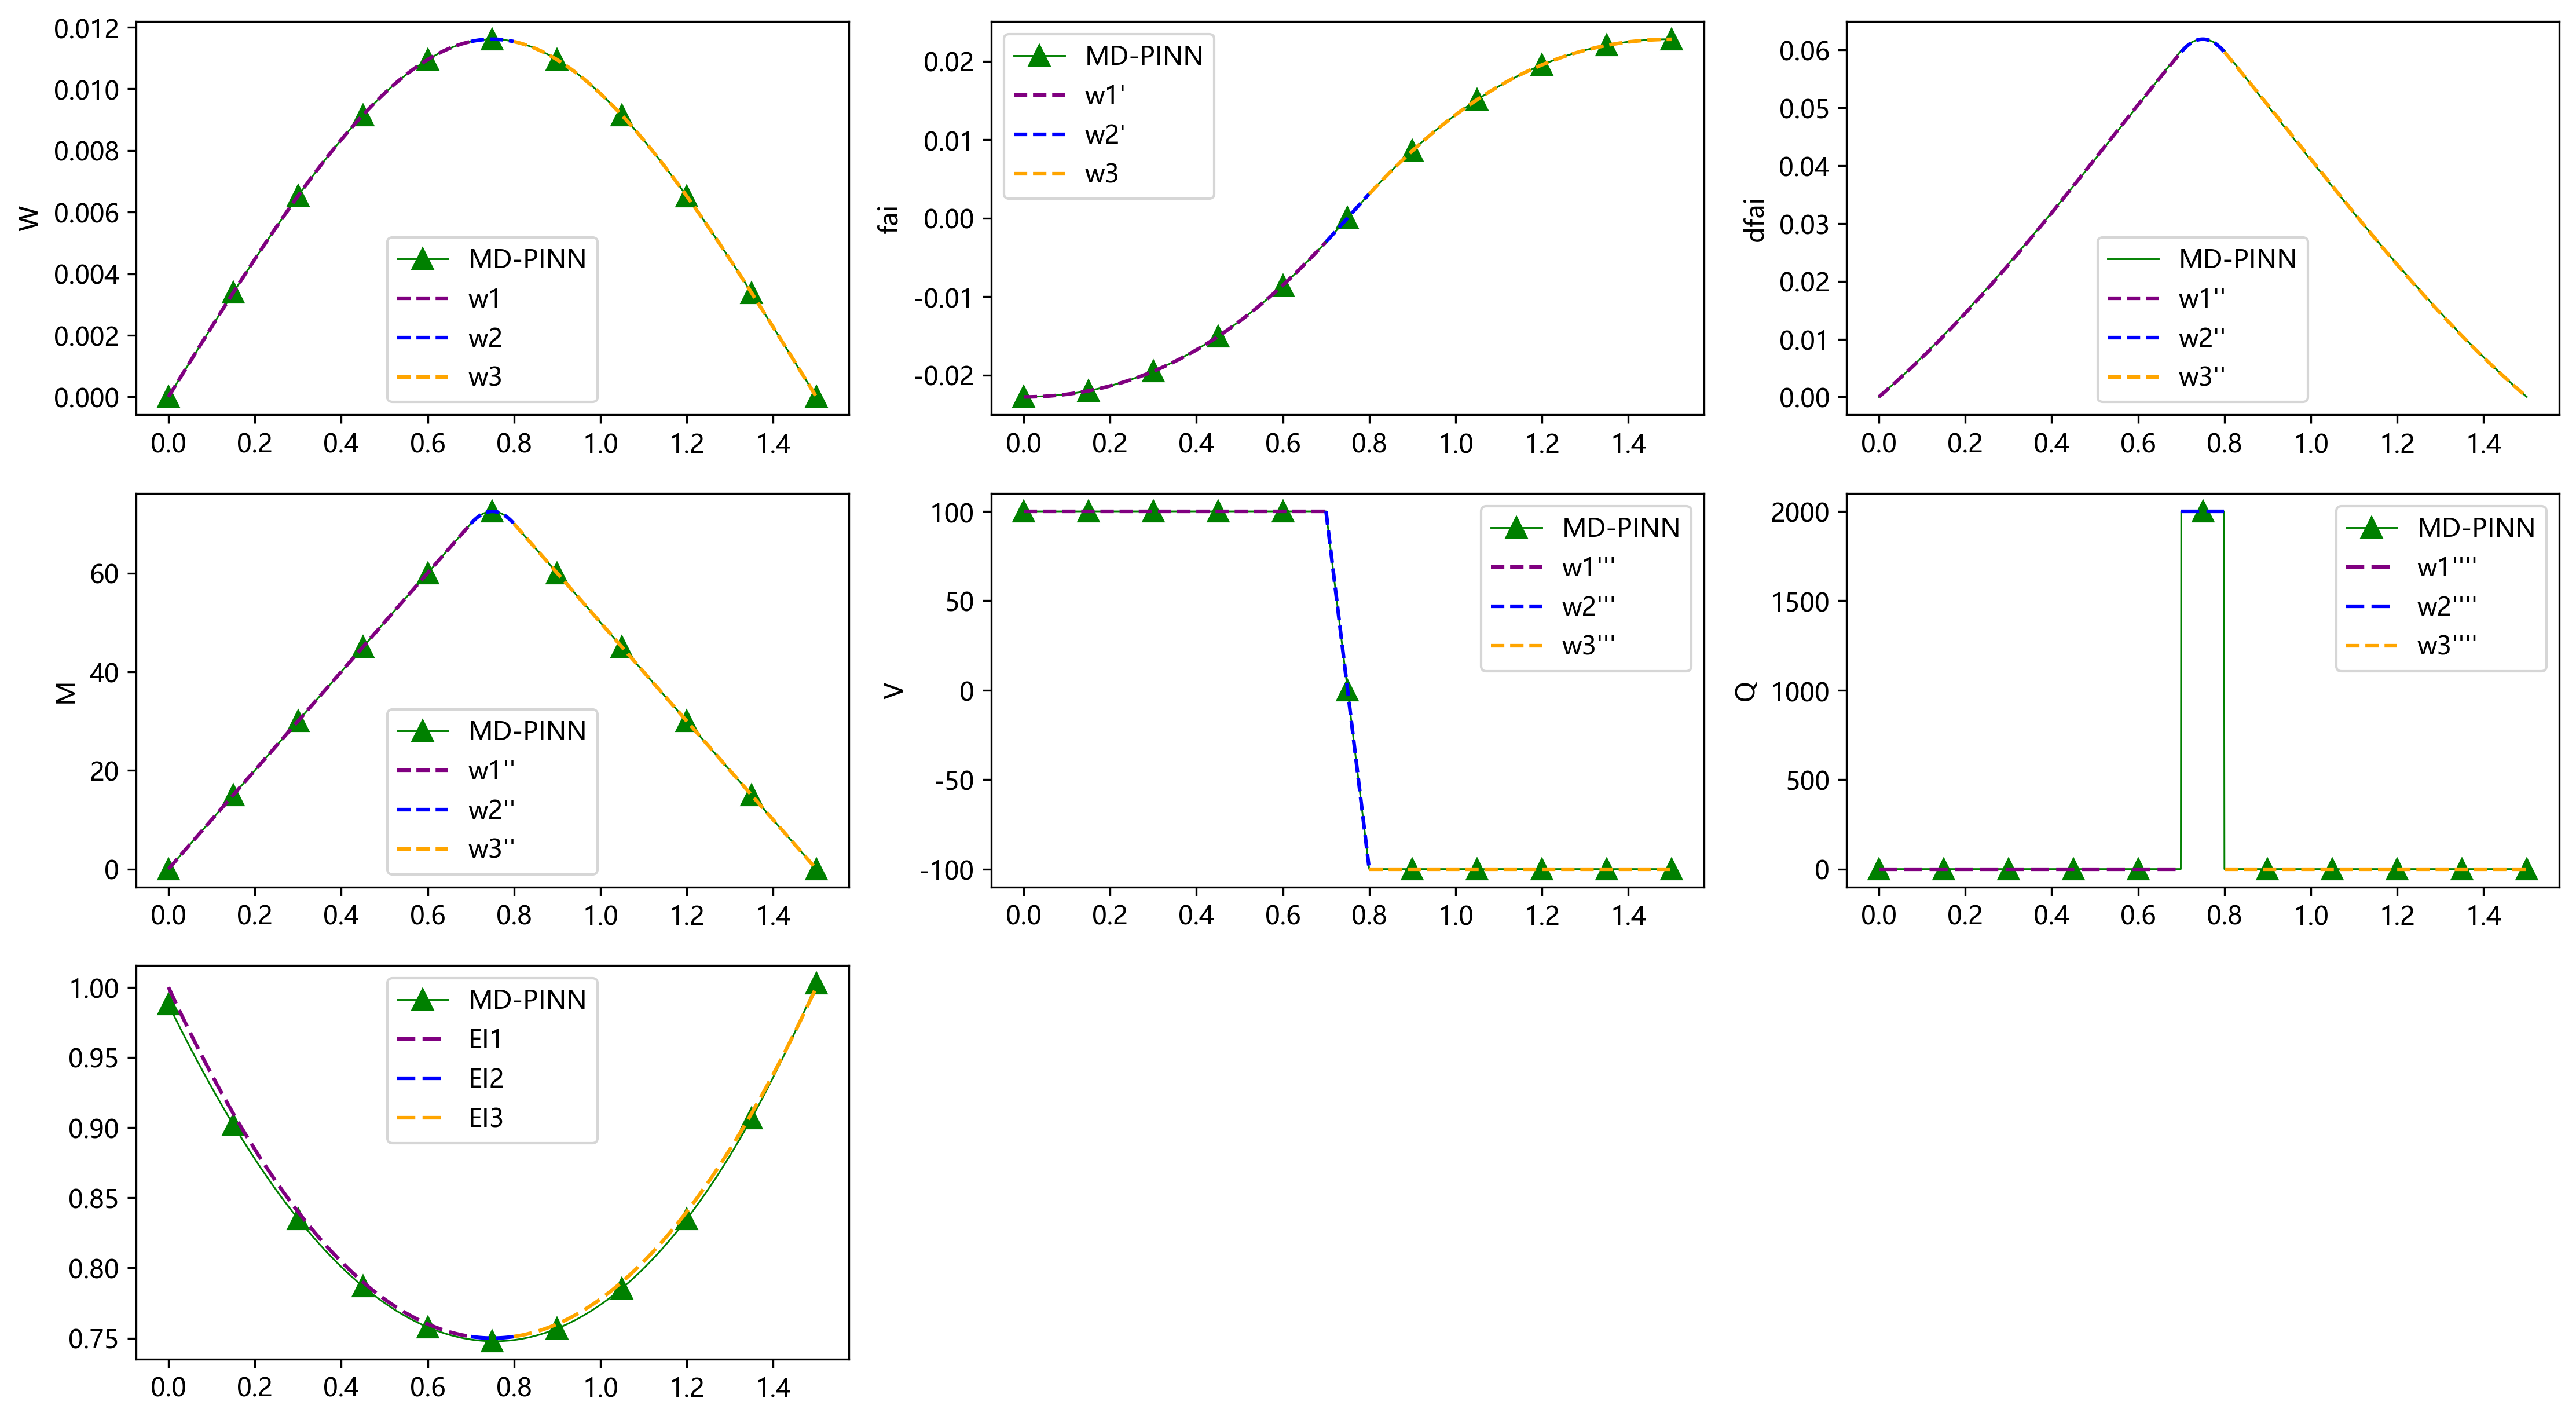

In [22]:
Norm,[W,fai,dfai,M,V,Q,EI] = Norm_exact(P =1)
plt.rcParams.update({'font.size': 10.5})
markersize=8
markevery=150
X2 = X1
plt.figure(figsize=(18,10),dpi=150)
plt.subplot(3,3,1)
plt.plot(X2, W, label='MD-PINN',color='green',marker='^',markersize=markersize,markevery=markevery,linewidth=0.7)
plt.ylabel('W')
plt.legend()

plt.subplot(3,3,2)
plt.plot(X2, fai, label='MD-PINN',color='green',marker='^',markersize=markersize,markevery=markevery,linewidth=0.7)
plt.ylabel('fai')
plt.legend()

plt.subplot(3,3,3)
plt.plot(X2, dfai, label='MD-PINN',color='green',linewidth=0.7)
plt.ylabel('dfai')
plt.legend()

plt.subplot(3,3,4)
plt.plot(X2, M, label='MD-PINN',color='green',marker='^',markersize=markersize,markevery=markevery,linewidth=0.7)
plt.ylabel('M')
plt.legend()

plt.subplot(3,3,5)
plt.plot(X2, V, label='MD-PINN',color='green',marker='^',markersize=markersize,markevery=markevery,linewidth=0.7)
plt.ylabel('V')
plt.legend()

plt.subplot(3,3,6)
plt.plot(X2, Q, label='MD-PINN',color='green',marker='^',markersize=markersize,markevery=markevery,linewidth=0.7)
plt.ylabel('Q')
plt.legend()
plt.subplot(3, 3, 7)
plt.plot(X2, EI/EI_real, label='MD-PINN',color='green',marker='^',markersize=markersize,markevery=markevery,linewidth=0.7)
# plt.ylim(0,2)
plt.legend()



####真解
d1 = L/2 - L_dis/2
d2 = L/2 + L_dis/2
interv1 = (X1>=0)&(X1<d1)
interv2 = (X1>=d1)&(X1<d2)
interv3 = (X1>=d2)&(X1<=L+0.001)
x_vals_w0 = X1[interv1].reshape(-1,1)
x_vals_w1 = X1[interv2].reshape(-1,1)
x_vals_w2 = X1[interv3].reshape(-1,1)
# plt.figure(figsize=(18,7),dpi=150)
plt.subplot(3, 3, 1)
W1 = WW1[interv1].reshape(-1,1)
W2 = WW1[interv2].reshape(-1,1)
W3 = WW1[interv3].reshape(-1,1)
plt.plot(x_vals_w0, W1, label='w1',linestyle='dashed', color='purple')
plt.plot(x_vals_w1, W2, label='w2',linestyle='dashed', color='blue')
plt.plot(x_vals_w2, W3, label='w3',linestyle='dashed', color='orange')
# plt.title('w1 and w2')
plt.legend()

plt.subplot(3, 3, 2)
dW1 = dWW1[interv1].reshape(-1,1)
dW2 = dWW1[interv2].reshape(-1,1)
dW3 = dWW1[interv3].reshape(-1,1)
plt.plot(x_vals_w0, dW1, label="w1'", linestyle='dashed', color='purple')
plt.plot(x_vals_w1, dW2, label="w2'", linestyle='dashed', color='blue')
plt.plot(x_vals_w2, dW3, label='w3',linestyle='dashed', color='orange')
# plt.title('First Derivative')
plt.legend()


plt.subplot(3, 3, 3)
ddfai1 = dfai_real[interv1].reshape(-1,1)
ddfai2 = dfai_real[interv2].reshape(-1,1)
ddfai3 = dfai_real[interv3].reshape(-1,1)
plt.plot(x_vals_w0, ddfai1, label="w1''", linestyle='dashed', color='purple')
plt.plot(x_vals_w1, ddfai2, label="w2''", linestyle='dashed', color='blue')
plt.plot(x_vals_w2, ddfai3, label="w3''", linestyle='dashed', color='orange')
# plt.title('Second Derivative')
plt.legend()

plt.subplot(3, 3, 4)
ddW1 = ddWW1[interv1].reshape(-1,1)
ddW2 = ddWW1[interv2].reshape(-1,1)
ddW3 = ddWW1[interv3].reshape(-1,1)
plt.plot(x_vals_w0, ddW1, label="w1''", linestyle='dashed', color='purple')
plt.plot(x_vals_w1, ddW2, label="w2''", linestyle='dashed', color='blue')
plt.plot(x_vals_w2, ddW3, label="w3''", linestyle='dashed', color='orange')
# plt.title('Second Derivative')
plt.legend()

plt.subplot(3, 3, 5)
dddW1 = dddWW1[interv1].reshape(-1,1)
dddW2 = dddWW1[interv2].reshape(-1,1)
dddW3 = dddWW1[interv3].reshape(-1,1)
plt.plot(x_vals_w0, dddW1, label="w1'''", linestyle='dashed', color='purple')
plt.plot(x_vals_w1, dddW2, label="w2'''", linestyle='dashed', color='blue')
plt.plot(x_vals_w2, dddW3, label="w3'''", linestyle='dashed', color='orange')
# plt.title('Third Derivative')
plt.legend()

plt.subplot(3, 3, 6)
ddddW1 = ddddWW1[interv1].reshape(-1,1)
ddddW2 = ddddWW1[interv2].reshape(-1,1)
ddddW3 = ddddWW1[interv3].reshape(-1,1)
plt.plot(x_vals_w0, ddddW1, label="w1''''", linestyle=(0, (5, 2)), color='purple')
plt.plot(x_vals_w1, ddddW2, label="w2''''", linestyle=(0, (5, 2)), color='blue')
plt.plot(x_vals_w2, ddddW3, label="w3''''",linestyle='dashed', color='orange')
# plt.title('Fourth Derivative')
plt.legend()

plt.subplot(3, 3, 7)
plt.plot(x_vals_w0, NP_EI(x_vals_w0)/EI_real, label="EI1", linestyle=(0, (5, 2)), color='purple')
plt.plot(x_vals_w1, NP_EI(x_vals_w1)/EI_real, label="EI2", linestyle=(0, (5, 2)), color='blue')
plt.plot(x_vals_w2, NP_EI(x_vals_w2)/EI_real, label='EI3', linestyle=(0, (5, 2)), color='orange')
# plt.ylim(0,2)
plt.legend()